Code to validate some earlier results from Pennington, on the spectrum of Jacobian for randomly intialized networks. 

In [1]:
import torch
import matplotlib.pyplot as plt

# Set device to MPS if available, otherwise use CUDA or CPU
device = torch.device("mps") if hasattr(torch, 'mps') and torch.backends.mps.is_available() else \
         torch.device("cuda") if torch.cuda.is_available() else \
         torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [20]:
def gaussian_product(L, D, scaling=None, dtype=torch.double):
    if scaling is None:
        scaling = 1.0 / torch.sqrt(torch.tensor(D, dtype=dtype))
    matrices = [scaling * torch.randn(D, D, device=device, dtype=dtype) for _ in range(L)]
    product = matrices[0]
    for i in range(1, L):
        product = product @ matrices[i]
    return product

def gaussian_product_svd(L, D, scaling=None, dtype=torch.double):
    product = gaussian_product(L, D, scaling, dtype)
    U, singular_values, V = torch.linalg.svd(product)
    return U, singular_values, V


def gaussian_random_activation_product(L, D, p_active=0.5, scaling=None, dtype=torch.double):
    if scaling is None:
        scaling = 1.0 / torch.sqrt(torch.tensor(D, dtype=dtype))
    matrices = [scaling * torch.randn(D, D, device=device, dtype=dtype) for _ in range(L)]
    product = matrices[0]
    for i in range(1, L):
        product = product @ matrices[i]
        active_mask = (torch.rand(D, device=device, dtype=dtype) < p_active).to(dtype)
        product = product @ torch.diag(active_mask)
    return product




Using device: mps
Max singular value: 1.1697e+01
Min singular value: 1.5213e-09
Condition number: 7.6886e+09


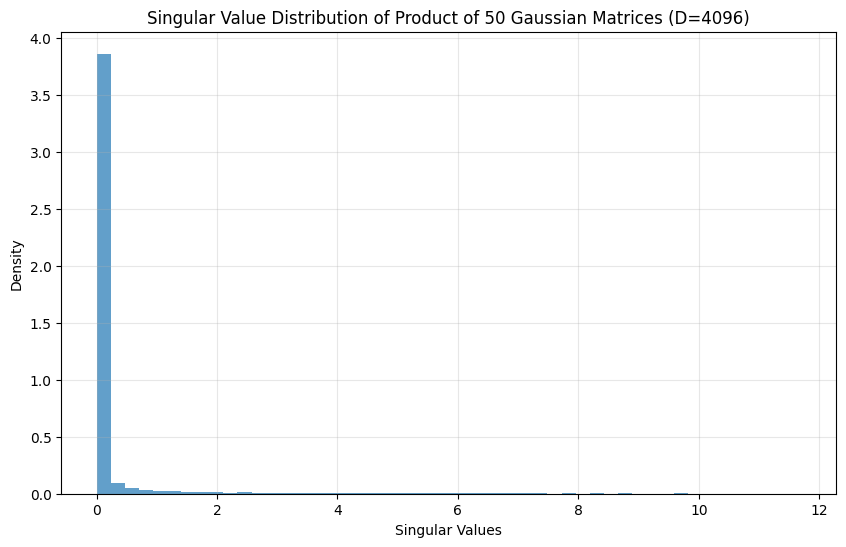

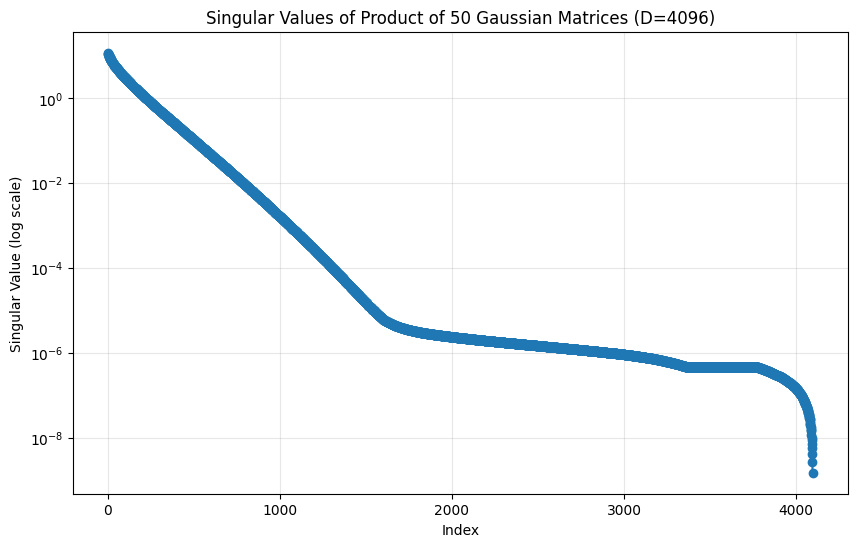

In [35]:
# Parameters
L = 50  # Number of matrices to multiply
D = 4096  # Dimension of matrices
sigma = 1.0 / torch.sqrt(torch.tensor(D, dtype=torch.double))  # Standard deviation for Gaussian entries

# Generate L random Gaussian matrices
# matrices = [torch.normal(0, sigma, size=(D, D), device=device) for _ in range(L)]
matrices = [sigma * torch.randn(D, D, device=device) for _ in range(L)]

# Compute the product of all matrices
product = matrices[0]
for i in range(1, L):
    product = product @ matrices[i]

# Compute the singular value decomposition
U, singular_values, V = torch.linalg.svd(product)

# Move singular values to CPU for plotting
singular_values = singular_values.cpu().numpy()

# Plot the distribution of singular values
plt.figure(figsize=(10, 6))
plt.hist(singular_values, bins=50, density=True, alpha=0.7)
plt.xlabel('Singular Values')
plt.ylabel('Density')
plt.title(f'Singular Value Distribution of Product of {L} Gaussian Matrices (D={D})')
plt.grid(True, alpha=0.3)

# Plot singular values on log scale
plt.figure(figsize=(10, 6))
plt.semilogy(range(1, D+1), singular_values, 'o-')
plt.xlabel('Index')
plt.ylabel('Singular Value (log scale)')
plt.title(f'Singular Values of Product of {L} Gaussian Matrices (D={D})')
plt.grid(True, alpha=0.3)

# Display some statistics
print(f"Max singular value: {singular_values.max():.4e}")
print(f"Min singular value: {singular_values.min():.4e}")
print(f"Condition number: {singular_values.max() / singular_values.min():.4e}")


In [3]:
L = 5
D = 4096
_, singular_values, _ = gaussian_product_svd(L, D)

Mean singular value: 3.3714e-01
Median singular value: 1.0088e-03
Standard deviation: 9.4623e-01
Ratio of max/mean: 2.2050e+01


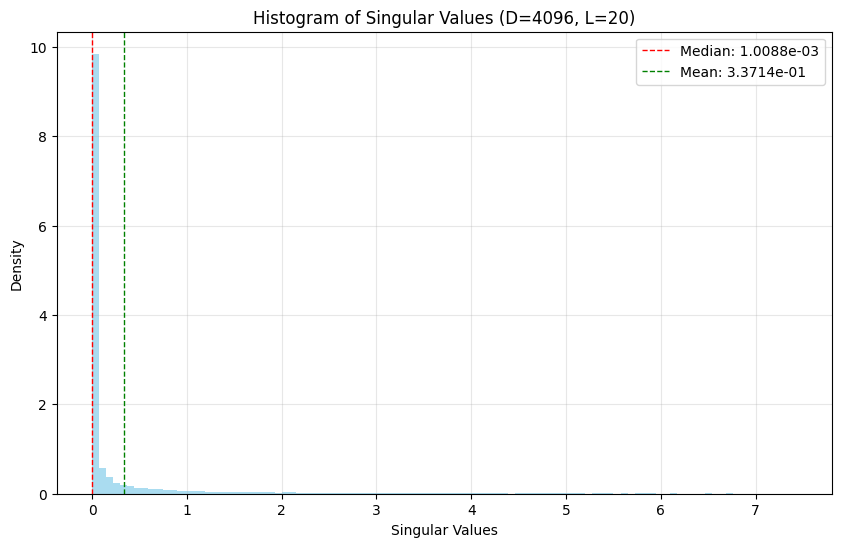

In [14]:
import numpy as np
# Plot histogram of singular values with more detailed analysis
plt.figure(figsize=(10, 6))
# plt.hist(np.log(singular_values), bins=100, density=True, alpha=0.7, color='skyblue')
plt.hist(singular_values, bins=100, density=True, alpha=0.7, color='skyblue')
plt.xlabel('Singular Values')
plt.ylabel('Density')
plt.title(f'Histogram of Singular Values (D={D}, L={L})')
plt.grid(True, alpha=0.3)

# Add some statistics to the plot
median_sv = np.median(singular_values)
mean_sv = np.mean(singular_values)
plt.axvline(median_sv, color='red', linestyle='dashed', linewidth=1, label=f'Median: {median_sv:.4e}')
plt.axvline(mean_sv, color='green', linestyle='dashed', linewidth=1, label=f'Mean: {mean_sv:.4e}')
plt.legend()
# plt.xscale("log")

# Print additional statistics
print(f"Mean singular value: {mean_sv:.4e}")
print(f"Median singular value: {median_sv:.4e}")
print(f"Standard deviation: {np.std(singular_values):.4e}")
print(f"Ratio of max/mean: {singular_values.max() / mean_sv:.4e}")


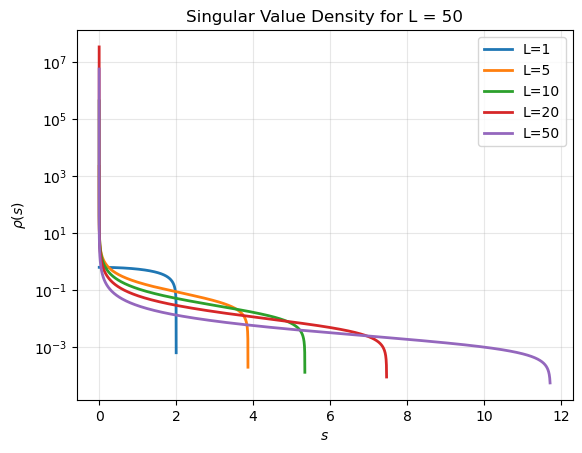

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def density_s(L, phi):
    """
    Computes the density rho(s(phi)) for a given L and phi.
    """
    # Inside the square root: sin^3(phi) * sin^(L-2)(L*phi) * sin((L+1)*phi)
    num = (np.sin(phi)**3) * (np.sin(L * phi)**(L - 2)) 
    denom = np.sin((L + 1) * phi)**(L - 1)
    return (2.0 / np.pi) * np.sqrt(num / denom)

def s_of_phi(L, phi):
    """
    Computes the mapping s(phi) for a given L and phi.
    """
    # s(phi) = sqrt( sin^((L+1))((L+1)phi) / ( sin(phi) * sin^L(L*phi) ) )
    num = np.sin((L + 1) * phi)**(L + 1)
    den = np.sin(phi) * (np.sin(L * phi)**L)
    return np.sqrt(num / den)


def compute_density(L, n_phi=1000, epsilon=1e-2):
    phi = np.linspace(epsilon, np.pi/(L + 1) - epsilon, n_phi)
    s_vals = s_of_phi(L, phi)
    rho_vals = density_s(L, phi)
    return s_vals, rho_vals


def plot_density(L, n_phi=1000, xscale="linear", epsilon=1e-2, yscale="linear", ax=None):
    """
    Plots the singular value density rho(s) for a product Wishart matrix of depth L.
    
    Parameters:
    - L: Number of factors in the product Wishart model.
    - n_phi: Number of phi points in the interval (0, pi/(L+1)) to sample.
    """
    # Avoid endpoints where sin goes to zero
    phi = np.linspace(epsilon, np.pi/(L + 1) - epsilon, n_phi)
    s_vals = s_of_phi(L, phi)
    rho_vals = density_s(L, phi)
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    else:
        fig = ax.figure
        plt.sca(ax)

    plt.plot(s_vals, rho_vals, lw=2, label=f'L={L}')
    plt.xscale(xscale)
    plt.xlabel(r'$s$')
    plt.yscale(yscale)
    plt.ylabel(r'$\rho(s)$')
    plt.title(f'Singular Value Density for L = {L}')
    plt.grid(alpha=0.3)
    # plt.show()
    return fig, ax

# Example usage: plot for L = 3
ax = None
for L in [1, 5, 10, 20, 50]:
    fig, ax = plot_density(L=L, xscale="linear", epsilon=1e-3, yscale="log", ax=ax)
ax.legend()
plt.show()

In [5]:
from tqdm import trange

In [7]:
SV_col.shape

torch.Size([20, 4096])

100%|██████████| 50/50 [00:11<00:00,  4.20it/s]


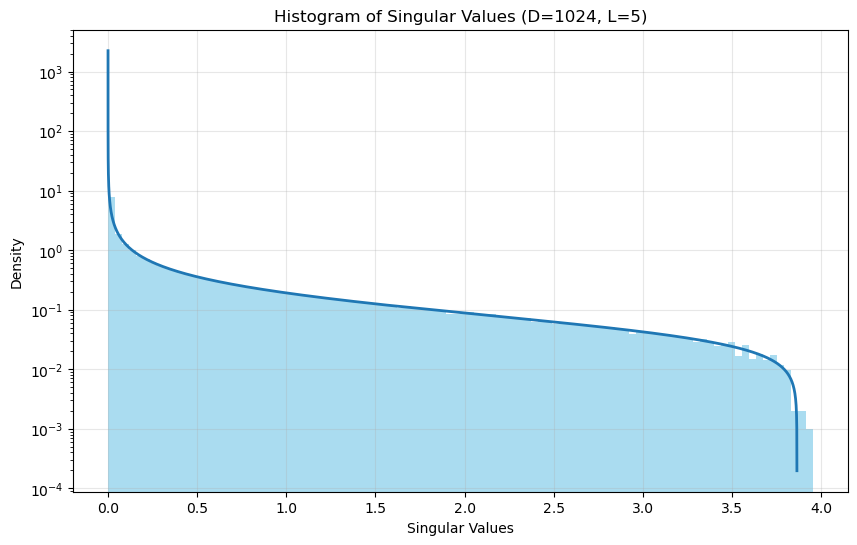

In [11]:
L = 5
D = 1024
SV_col = []
for repeat in trange(50):
    _, singular_values, _ = gaussian_product_svd(L, D)
    SV_col.append(singular_values)
SV_col = torch.stack(SV_col, dim=0)

s_vals, rho_vals = compute_density(L, n_phi=1000, epsilon=1e-3)
plt.figure(figsize=(10, 6))
plt.hist(SV_col.cpu().flatten(), bins=100, density=True, alpha=0.7, color='skyblue')
plt.plot(s_vals, rho_vals, lw=2, label=f'L={L}')
plt.xlabel('Singular Values')
plt.ylabel('Density')
plt.yscale("log")
plt.title(f'Histogram of Singular Values (D={D}, L={L})')
plt.grid(True, alpha=0.3)

100%|██████████| 50/50 [00:52<00:00,  1.05s/it]


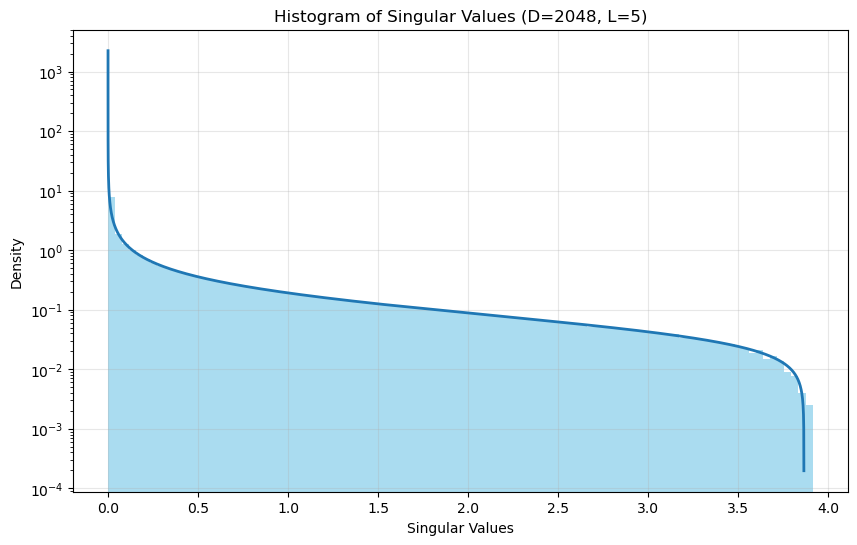

In [12]:
L = 5
D = 2048
SV_col = []
for repeat in trange(50):
    _, singular_values, _ = gaussian_product_svd(L, D)
    SV_col.append(singular_values)
SV_col = torch.stack(SV_col, dim=0)

s_vals, rho_vals = compute_density(L, n_phi=1000, epsilon=1e-3)
plt.figure(figsize=(10, 6))
plt.hist(SV_col.cpu().flatten(), bins=100, density=True, alpha=0.7, color='skyblue')
plt.plot(s_vals, rho_vals, lw=2, label=f'L={L}')
plt.xlabel('Singular Values')
plt.ylabel('Density')
plt.yscale("log")
plt.title(f'Histogram of Singular Values (D={D}, L={L})')
plt.grid(True, alpha=0.3)

100%|██████████| 10/10 [03:03<00:00, 18.40s/it]


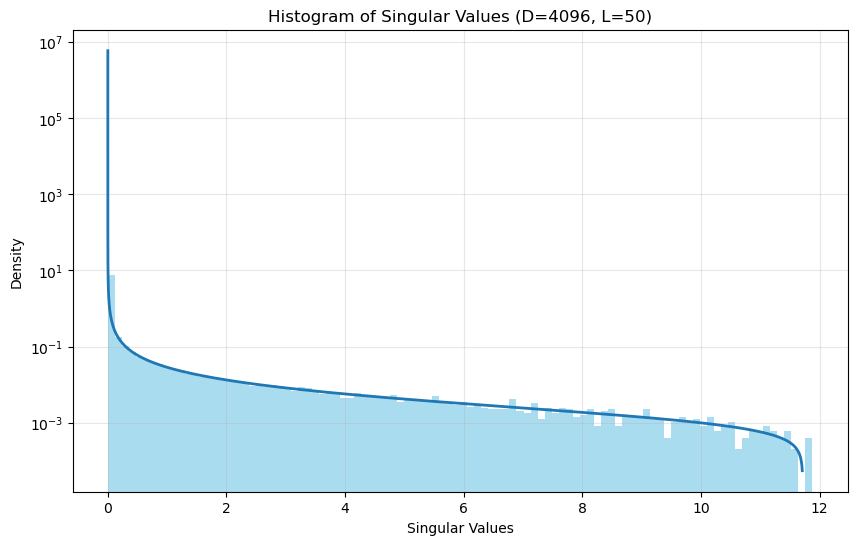

In [15]:
L = 50
D = 4096
SV_col = []
for repeat in trange(10):
    _, singular_values, _ = gaussian_product_svd(L, D, dtype=torch.float)
    SV_col.append(singular_values)
SV_col = torch.stack(SV_col, dim=0)

s_vals, rho_vals = compute_density(L, n_phi=1000, epsilon=1e-3)
plt.figure(figsize=(10, 6))
plt.hist(SV_col.cpu().flatten(), bins=100, density=True, alpha=0.7, color='skyblue')
plt.plot(s_vals, rho_vals, lw=2, label=f'L={L}')
plt.xlabel('Singular Values')
plt.ylabel('Density')
plt.yscale("log")
plt.title(f'Histogram of Singular Values (D={D}, L={L})')
plt.grid(True, alpha=0.3)

In [16]:
L = 50
D = 4096
SV_col = []
for repeat in trange(10):
    _, singular_values, _ = gaussian_product_svd(L, D, dtype=torch.float)
    SV_col.append(singular_values)
SV_col = torch.stack(SV_col, dim=0)

s_vals, rho_vals = compute_density(L, n_phi=1000, epsilon=1e-3)
plt.figure(figsize=(10, 6))
plt.hist(SV_col.cpu().flatten(), bins=100, density=True, alpha=0.7, color='skyblue')
plt.plot(s_vals, rho_vals, lw=2, label=f'L={L}')
plt.xlabel('Singular Values')
plt.ylabel('Density')
plt.yscale("log")
plt.title(f'Histogram of Singular Values (D={D}, L={L})')
plt.grid(True, alpha=0.3)

 40%|████      | 4/10 [00:35<00:53,  8.99s/it]


KeyboardInterrupt: 

100%|██████████| 10/10 [01:42<00:00, 10.21s/it]


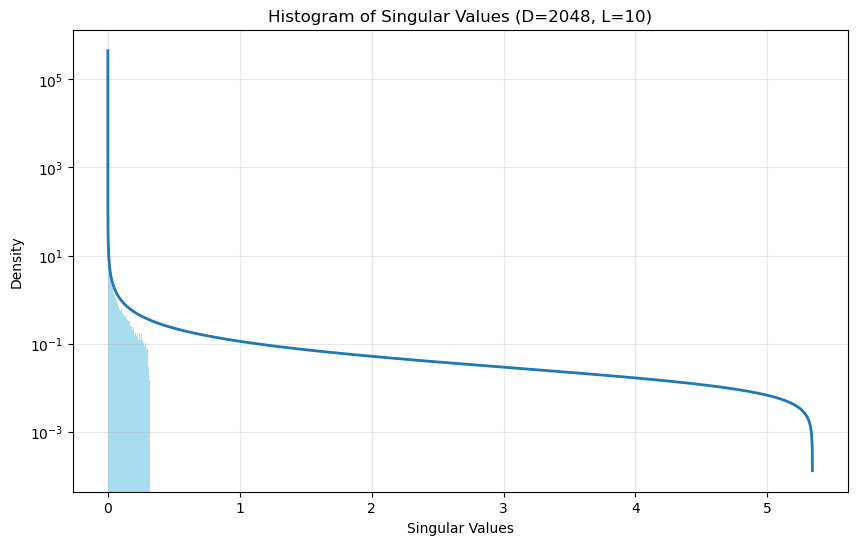

In [22]:
L = 10
D = 2048
SV_col = []
for repeat in trange(10):
    rand_product = gaussian_random_activation_product(L, D, p_active=0.5, dtype=torch.float)
    _, singular_values, _ = torch.linalg.svd(rand_product)
    SV_col.append(singular_values)
SV_col = torch.stack(SV_col, dim=0)

s_vals, rho_vals = compute_density(L, n_phi=1000, epsilon=1e-3)
plt.figure(figsize=(10, 6))
plt.hist(SV_col.cpu().flatten(), bins=100, density=True, alpha=0.7, color='skyblue')
plt.plot(s_vals, rho_vals, lw=2, label=f'L={L}')
plt.xlabel('Singular Values')
plt.ylabel('Density')
plt.yscale("log")
plt.title(f'Histogram of Singular Values (D={D}, L={L})')
plt.grid(True, alpha=0.3)

100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


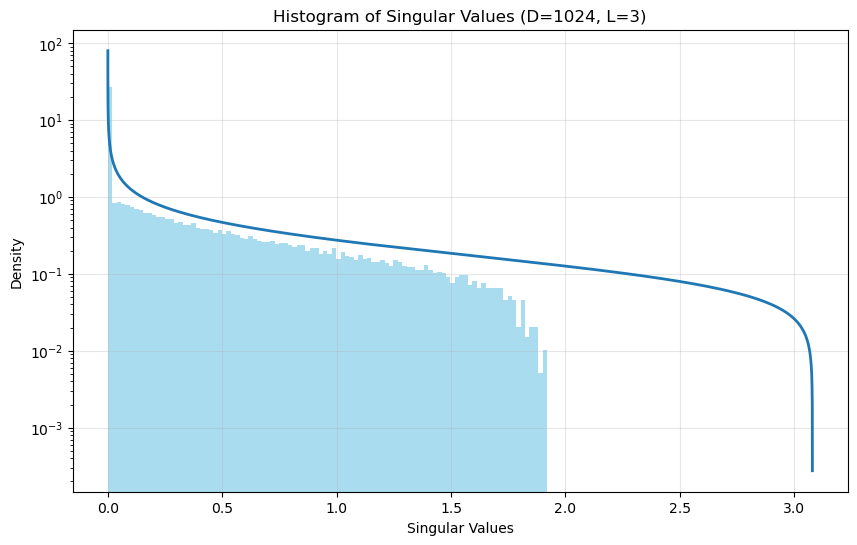

In [38]:
L = 3
D = 1024
SV_col = []
for repeat in trange(10):
    rand_product = gaussian_random_activation_product(L, D, p_active=.5, dtype=torch.float)
    _, singular_values, _ = torch.linalg.svd(rand_product)
    SV_col.append(singular_values)
SV_col = torch.stack(SV_col, dim=0)

s_vals, rho_vals = compute_density(L, n_phi=1000, epsilon=1e-3)
plt.figure(figsize=(10, 6))
plt.hist(SV_col.cpu().flatten(), bins=100, density=True, alpha=0.7, color='skyblue')
plt.plot(s_vals, rho_vals, lw=2, label=f'L={L}')
plt.xlabel('Singular Values')
plt.ylabel('Density')
plt.yscale("log")
plt.title(f'Histogram of Singular Values (D={D}, L={L})')
plt.grid(True, alpha=0.3)

100%|██████████| 20/20 [00:37<00:00,  1.87s/it]


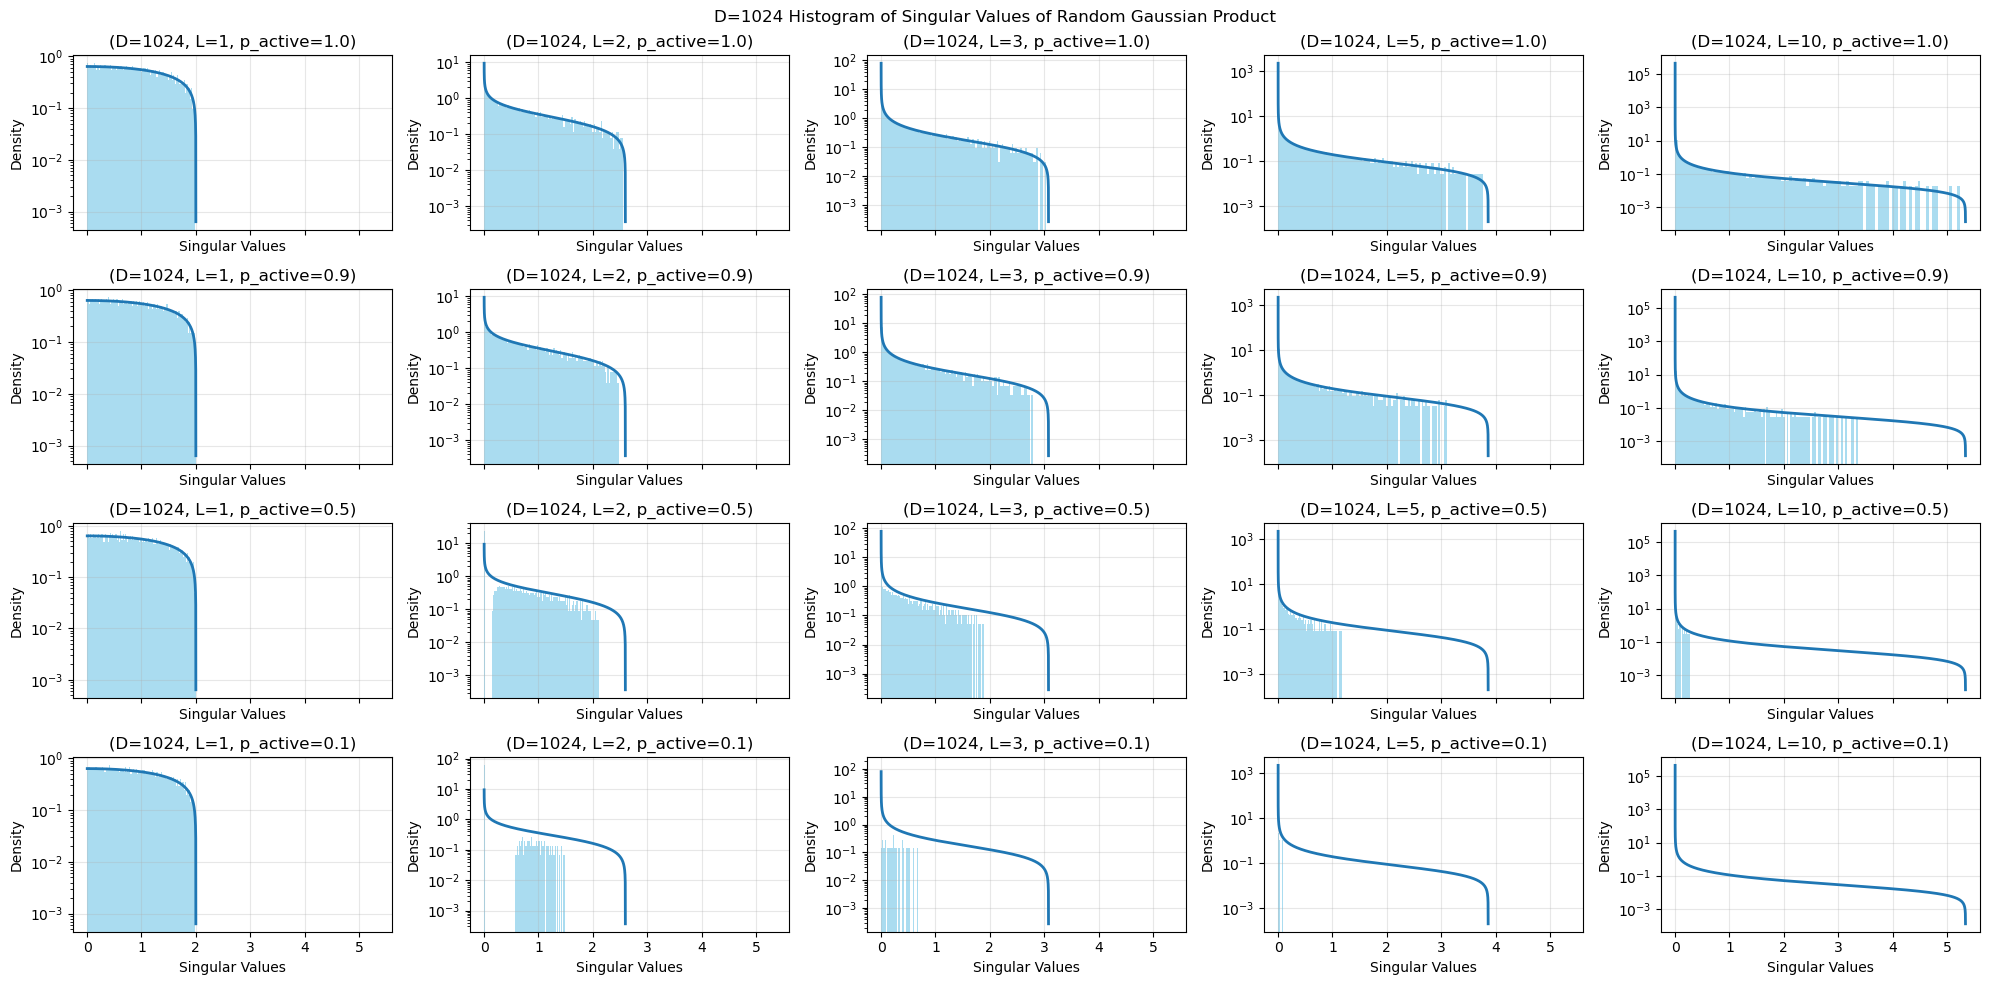

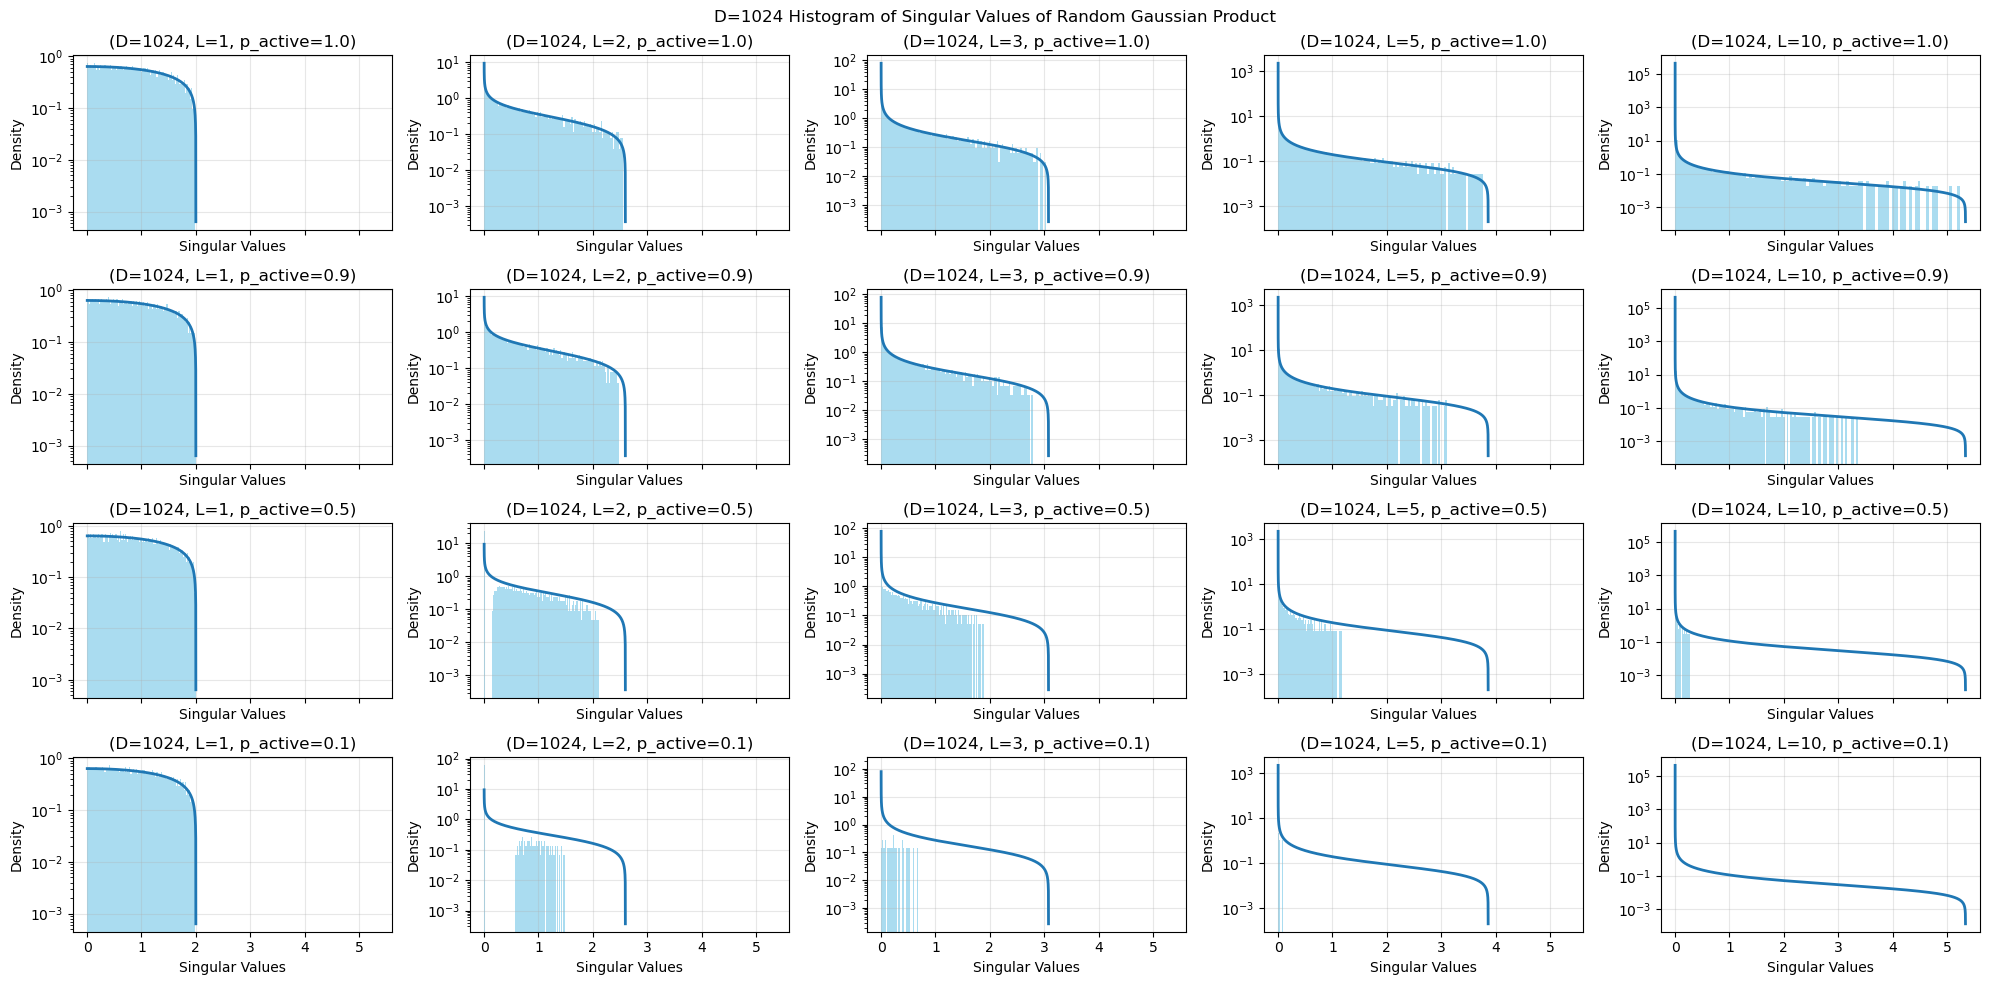

In [99]:
# L = 3
D = 1024
L_list = [1, 2, 3, 5, 10, ]
p_active_list = [1.0, 0.9, 0.5, 0.1]
# plt.figure(figsize=(10, 6))
figh, axs = plt.subplots(len(p_active_list), len(L_list), figsize=(20, 10), sharex='all',)
for iL, L in enumerate(L_list): 
    for ip_active, p_active in enumerate(p_active_list):
        SV_col = []
        for repeat in trange(20):
            rand_product = gaussian_random_activation_product(L, D, p_active=p_active, dtype=torch.float)
            _, singular_values, _ = torch.linalg.svd(rand_product)
        SV_col.append(singular_values)
        SV_col = torch.stack(SV_col, dim=0)

        s_vals, rho_vals = compute_density(L, n_phi=1000, epsilon=1e-3)
        plt.sca(axs[ip_active, iL])
        plt.hist(SV_col.cpu().flatten(), bins=100, density=True, alpha=0.7, color='skyblue', label=f'L={L} p={p_active}')
        plt.plot(s_vals, rho_vals, lw=2, label=f'L={L}')
        plt.xlabel('Singular Values')
        plt.ylabel('Density')
        plt.yscale("log")
        plt.title(f'(D={D}, L={L}, p_active={p_active})')
        plt.grid(True, alpha=0.3)
plt.suptitle(f'D={D} Histogram of Singular Values of Random Gaussian Product')
figh.tight_layout()
figh

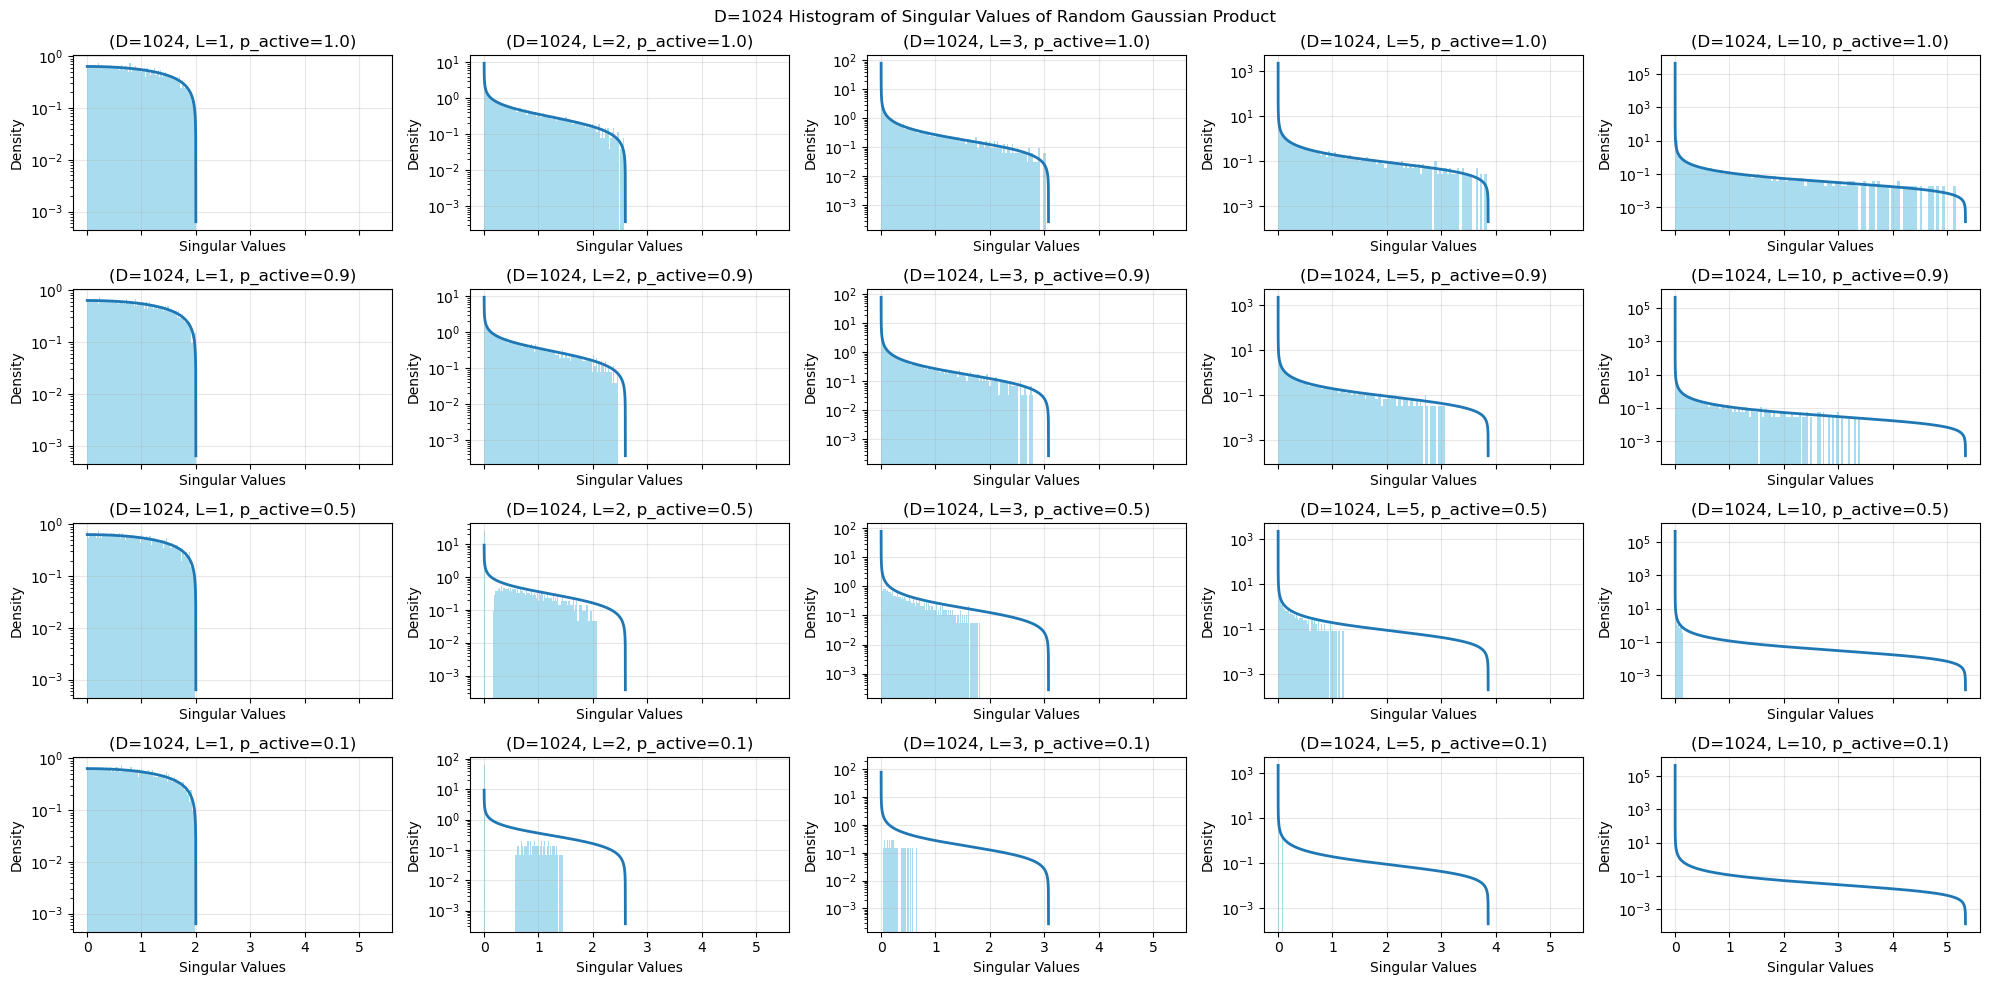

In [44]:
figh.tight_layout()
figh

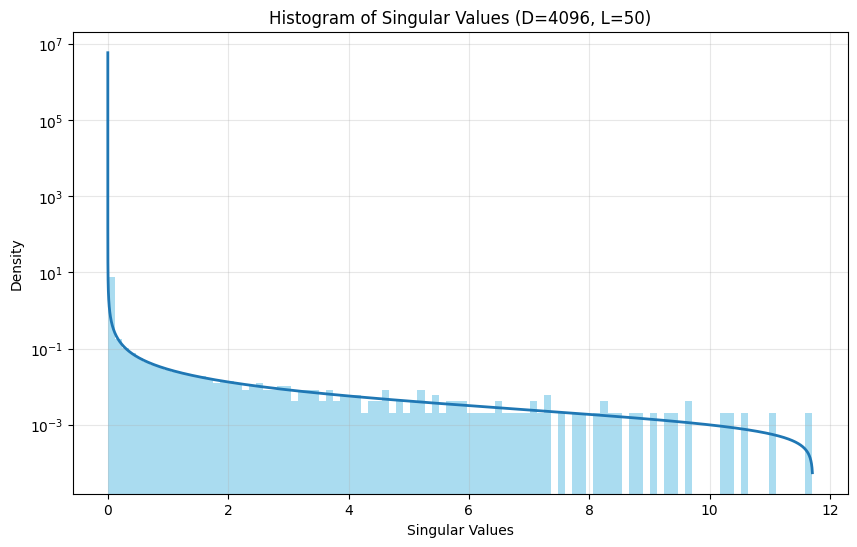

In [36]:
plt.figure(figsize=(10, 6))
# plt.hist(np.log(singular_values), bins=100, density=True, alpha=0.7, color='skyblue')
plt.hist(singular_values, bins=100, density=True, alpha=0.7, color='skyblue')
fig, ax = plot_density(L=50, xscale="linear", epsilon=1e-3, yscale="log", ax=plt.gca())
plt.xlabel('Singular Values')
plt.ylabel('Density')
plt.yscale("log")
plt.title(f'Histogram of Singular Values (D={D}, L={L})')
plt.grid(True, alpha=0.3)